In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils


import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

In [3]:
np.arange(0,100,2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

In [4]:
## look at https://wedocs.unep.org/bitstream/handle/20.500.11822/11406/Pog_&amp;_iPog_-_Energy_and_Fuels.pdf?sequence=1&amp%3BisAllowed=

## for emissions factors scaling

## fix tott

## Set constants

In [5]:
coal_year_range = np.arange(0,41)
percents = [0, 10, 20,30,40,50,60, 70,80,90]
years = [0,10,20,30]
coal_year_range = np.arange(0,41)

In [6]:
## Add time dimension
length_simulation = 50*365

time_array = np.arange(0, length_simulation)

## Data read in

### Emissions dataframe

In [7]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

In [8]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [9]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

loc_df = {}
mort_df = {}
for c in countries:
    #loc_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)
    mort_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)

    mask = country_mask.mask(ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c))
    for yr in years:
        for pc in percents:
            #print(yr,pc)
            #loc_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).sum().values
            mort_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).sum().values

    #loc_df[c] = loc_df[c].astype('float32')
    mort_df[c] = mort_df[c].astype('float32')
    #loc_df[c].to_csv(f'Outputs/{c}_early_shutdown_co2pct_sum.csv')

loc_mean_df = {}
for c in countries:
    loc_mean_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)
    mask = country_mask.mask(ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c))
    for yr in years:
        for pc in percents:
            #print(yr,pc)
            loc_mean_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).mean().values
    loc_mean_df[c] = loc_mean_df[c].astype('float32')
    #loc_mean_df[c].to_csv(f'Outputs/{c}_early_shutdown_co2pct_mean.csv')

## Read in loc mean ds

In [10]:
loc_mean_df = {}

In [11]:
loc_mean_df['China'] = xr.open_dataset('Outputs/China_early_shutdown_co2pct_mean.nc')

In [12]:
loc_mean_df

{'China': <xarray.Dataset>
 Dimensions:        (year_shutdown: 4, percent: 1)
 Coordinates:
   * year_shutdown  (year_shutdown) int64 0 10 20 30
   * percent        (percent) int64 1
     raster         int32 ...
 Data variables:
     BC_conc        (percent, year_shutdown) float64 ...
     AF             (percent, year_shutdown) float64 ...
     delta_I        (percent, year_shutdown) float64 ...}

## Dataframe for total CO2 emitted under each scenario

In [13]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    #print(CO2_val)
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['ANNUALCO2'].sum()
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        #print(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        #print(CO2_val)
        #print(df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum())
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [14]:
years_run = 50
coal_year_range = np.arange(0,41)

## Add time dimension
length_simulation = years_run
time_array = np.arange(0, length_simulation)

In [15]:
coal_yrs = years
percents = [100 - p for p in [0, 10, 20,30,40,50,60, 70,80,90, 99]]

In [16]:
E_CO2_range_max_allyr = {}
for year in coal_yrs:
    E_CO2_range_max_allyr[year] = {}
    for r in percents:
        E_CO2_range_max_allyr[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        E_CO2_range_max_allyr[year][r] = E_CO2_range_max_allyr[year][r].sum()

In [17]:
CO2_df = pd.DataFrame(E_CO2_range_max_allyr).T

In [18]:
CO2_df

,100,90,80,70,60,50,40,30,20,10,1
0,6.969109e+09,5.284966e+09,4.220253e+09,3.034138e+09,2.415592e+09,1.425720e+09,1.101421e+09,6.425864e+08,3.941545e+08,2.499926e+08,1.570634e+08
10,7.034487e+09,5.694047e+09,4.909702e+09,3.965651e+09,3.524570e+09,2.736713e+09,2.478597e+09,2.113402e+09,1.916402e+09,1.801661e+09,1.727697e+09
20,7.099865e+09,6.103128e+09,5.599152e+09,4.897165e+09,4.633548e+09,4.047705e+09,3.855773e+09,3.584218e+09,3.438650e+09,3.353330e+09,3.298331e+09
30,7.165243e+09,6.512208e+09,6.288602e+09,5.828679e+09,5.742526e+09,5.358698e+09,5.232949e+09,5.055034e+09,4.960898e+09,4.904998e+09,4.868965e+09


d = dict(zip(CO2_df.columns, np.arange(0,101)[::-1]))
CO2_df = CO2_df.rename(columns = d)

CO2_df.columns = [100 - p for p in CO2_df.columns] 

## Number of plants open

In [56]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    #print(CO2_val)
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['UNITID'].count()
    #print(df.loc[df.ANNUALCO2 >= CO2_val]['UNITID'].count())
    #print(E)
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        #print(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        #print(CO2_val)
        #print(df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum())
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['UNITID'].count()
        #print(E)
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [22]:
E_num_plants = {}
for year in coal_year_range:
    E_num_plants[year] = {}
    #E_num_plants_sum[year] = {}
    for r in np.arange(1,101):
        E_num_plants[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        #E_num_plants_sum[year][r] = E_num_plants[year][r].sum()
        

KeyboardInterrupt: 

In [ ]:
num_plants_df = pd.DataFrame(E_num_plants).T

## Plots

In [19]:
percents = [100 - p for p in percents]

In [20]:
percents.append(0)

In [21]:
mort_array = [[6.59548402e-01, 2.40733654e+03, 4.81401338e+03, 7.22069022e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.34858644e+03, 6.43418735e+03, 7.51978819e+03, 8.60538904e+03],
 [5.34858644e+03, 6.43418735e+03, 7.51978819e+03, 8.60538904e+03],
 [9.33407543e+03, 9.52134851e+03, 9.70862157e+03, 9.89589463e+03],
    [ 9983.71594052, 10041.05383127, 10098.39171899, 10155.72960671]]
mort_array = np.array(mort_array).T
mort_df = pd.DataFrame(mort_array, index = years, columns = [100 - p for p in percents[:-1]])

In [22]:
poll_array = [[4.89498131e-03, 7.15156769e+00, 1.78715768e+01, 2.85915858e+01,
  3.57382585e+01, 4.28849313e+01, 5.36049403e+01, 6.43249494e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [3.96953272e+01, 4.29196118e+01, 4.77560388e+01, 5.25924658e+01,
  5.58167505e+01, 5.90410351e+01, 6.38774621e+01, 6.87138891e+01],
 [3.96953272e+01, 4.29196118e+01, 4.77560388e+01, 5.25924658e+01,
  5.58167505e+01, 5.90410351e+01, 6.38774621e+01, 6.87138891e+01],
 [6.92861850e+01, 6.98424785e+01, 7.06769187e+01, 7.15113588e+01,
  7.20676523e+01, 7.26239457e+01, 7.34583859e+01, 7.42928261e+01],
 [7.41105060e+01, 7.42808326e+01, 7.45363226e+01, 7.47918125e+01,
  7.49621391e+01, 7.51324657e+01, 7.53879557e+01, 7.56434456e+01]]
poll_array = np.array(poll_array).T
poll_df = pd.DataFrame(poll_array, index = [0,4,10,16,20,24,30,36], columns = [100 - p for p in [0, 10, 20,30,40,50,60, 70,80,90, 99]])

AF = ((np.exp(beta*(country_df.loc[country_df['ADMIN'] == c][f'BC_conc_{y}_{p}_{t}']- 
mask_annual_base_ds.where(mask_annual_base_ds.country == c, drop = True).isel(year = t)['BC_conc'].values[0])) - 1)/
np.exp(beta*(country_df.loc[country_df['ADMIN'] == c][f'BC_conc_{y}_{p}_{t}']- 
mask_annual_base_ds.where(mask_annual_base_ds.country == c, drop = True).isel(year = t)['BC_conc'].values[0])))
#I0_pop

RR = 1.02 #global mean
del_x = 10 #ug/m3
beta = np.log(RR)/del_x

mort_df2 = beta*(poll_array-poll_array.min())*10462043.68/1.408e9 * 1.408e9 

AF = np.exp((beta * (poll_array - poll_array.min())) - 1)/np.exp(beta * (poll_array - poll_array.min()))

np.exp(beta * (poll_array - poll_array.min()))

np.exp(beta * (poll_array - poll_array.min()) - 1)

mort_df2 = AF * 10462043.68/1.408e9 * 1.408e9 

In [61]:
for r in percents[:-1]:
    for y in years:
        plt.plot(num_plants_df[r].loc[y])
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/all_trajectory.pdf', bbox_inches = 'tight', dpi = 350)   

NameError: name 'num_plants_df' is not defined

<AxesSubplot:ylabel='Frequency'>

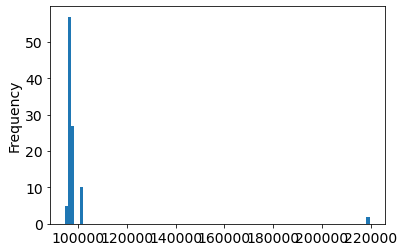

In [31]:
CGP_df['CO2_weighted_capacity_1000tonsperMW'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

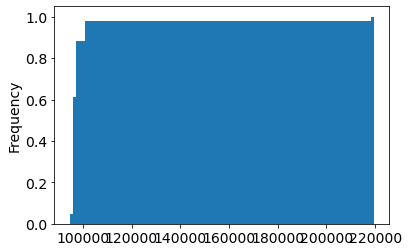

In [44]:
CGP_df['CO2_weighted_capacity_1000tonsperMW'].plot.hist(cumulative = True, density = True, bins = 100)

In [32]:

#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
    #print(min_comission_yr)
    #print(shutdown_days)
    test_array = np.where(time_array <= year_early*365, True, False)
    #print('test array len', len(test_array))
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
    #fig, ax = plt.subplots()
    #plt.plot(E)
    #plt.title('E')
    #print(E)
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        #print(np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #plt.plot(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)


# In[12]:



In [35]:

E_CO2_all_opts = {}
for year in [10,20,30]:
    E_CO2_all_opts[year] = {}
    for r in [10,20,30,40,50]:
        E_CO2_all_opts[year][r] = early_retirement_by_CO2_year(year, CGP_df, 
                                                               np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
print('Emis profiiles created')

Emis profiiles created


In [39]:
percents = np.arange(0,100)

In [41]:
for r in percents:
    print(r, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))

0 94600.0
1 94600.0
2 94600.0
3 94600.0
4 95350.0
5 96100.0
6 96100.0
7 96100.0
8 96100.0
9 96100.0
10 96100.0
11 96100.0
12 96100.0
13 96100.0
14 96100.0
15 96100.0
16 96100.0
17 96100.0
18 96100.0
19 96100.0
20 96100.0
21 96100.0
22 96100.0
23 96100.0
24 96100.0
25 96100.0
26 96100.0
27 96100.0
28 96100.0
29 96100.0
30 96100.0
31 96100.0
32 96100.0
33 96100.0
34 96100.0
35 96100.0
36 96100.0
37 96100.0
38 96100.0
39 96100.0
40 96100.0
41 96100.0
42 96100.0
43 96100.0
44 96100.0
45 96100.0
46 96100.0
47 96100.0
48 96100.0
49 96100.0
50 96100.0
51 96100.0
52 96100.0
53 96100.0
54 96100.0
55 96100.0
56 96100.0
57 96100.0
58 96100.0
59 96100.0
60 96100.0
61 96100.0
62 98300.0
63 98300.0
64 98300.0
65 98300.0
66 98300.0
67 98300.0
68 98300.0
69 98300.0
70 98300.0
71 98300.0
72 98300.0
73 98300.0
74 98300.0
75 98300.0
76 98300.0
77 98300.0
78 98300.0
79 98300.0
80 98300.0
81 98300.0
82 98300.0
83 98300.0
84 98300.0
85 98300.0
86 98300.0
87 98300.0
88 98300.0
89 101000.0
90 101000.0
91 1010

In [36]:
E_CO2_all_opts[year][r]

array([337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766, 337.42884766, 337.42884766,
       337.42884766, 337.42884766])

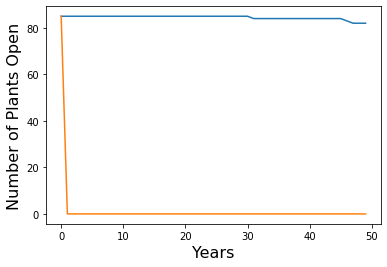

In [110]:
#for year in [10,40]:
    #for r in [10]:
plt.plot(num_plants_df[100].loc[30]+4)
plt.plot(num_plants_df[1].loc[0])

plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/ex_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

In [62]:
percents = [0, 10, 20,30,40,50,60, 70,80,90,99]
#percents = [100 - p for p in percents]
#percents.append(0)

In [68]:
years = [40 - y for y in years]

In [72]:
years = years[::-1]

In [77]:
years

[10, 20, 30, 40]

In [82]:
CO2_df.index = [40 - y for y in years]

Int64Index([0, 10, 20, 30], dtype='int64')

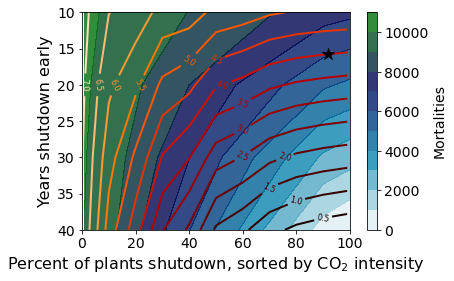

In [98]:
plt.rcParams.update({'font.size': 14})

contours = plt.contour(percents, years[::-1], CO2_df[:].values*1e-9, cmap = 'gist_heat', 
                       levels = np.arange(0,8,.5), linewidths = 2)
plt.clabel(contours, fontsize=8, inline = True)

plt.contourf([100,90,10,1], years[::-1], mort_df[:][[100,90,10,1]].values, cmap = 'ocean_r', 
             levels = np.arange(0,12000,1000), alpha = .8)
plt.plot(92,40-24.2, 'k*', markersize = 12)
plt.colorbar(label = 'Mortalities')
#plt.title('Additional Mortalities over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years shutdown early', fontsize = 16)
plt.ylim(40,10)
#plt.xlim(30,100)
plt.savefig('figures/china_mort_BC_contours.png', bbox_inches = 'tight', dpi = 350)

In [26]:
mort_df[:]

,100,90,80,70,60,50,40,30,20,10,1
0,0.659548,553.755675,553.755675,553.755675,553.755675,553.755675,553.755675,5348.58644,5348.58644,9334.07543,9983.715941
10,2407.336540,2849.807370,2849.807370,2849.807370,2849.807370,2849.807370,2849.807370,6434.18735,6434.18735,9521.34851,10041.053831
20,4814.013380,5145.858920,5145.858920,5145.858920,5145.858920,5145.858920,5145.858920,7519.78819,7519.78819,9708.62157,10098.391719
30,7220.690220,7441.910470,7441.910470,7441.910470,7441.910470,7441.910470,7441.910470,8605.38904,8605.38904,9895.89463,10155.729607


## FIX THE INTENSITY VS ANNUAL CO2 and for  intensity, use the CDF!

Text(0, 0.5, 'Years until shutdown')

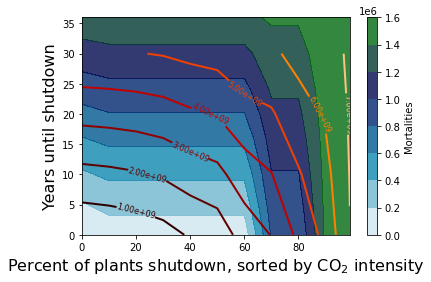

In [96]:

contours = plt.contour(percents[:-1][::-1], years, CO2_df[:], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents[:-1], [0,4,10,16,20,24,30,36], mort_df2[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'Mortalities')
#plt.title('Additional Mortalities over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
#plt.savefig('figures/china_mort_BC_contours.png', bbox_inches = 'tight', dpi = 350)

In [80]:
mort_df2

array([[3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962],
       [3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962],
       [3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962],
       [3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962, 3848770.78250962,
        3848770.78250962, 3848770.78250962],
       [3848770.78250962, 3848770.78250962, 3848770.78250962,
        384877

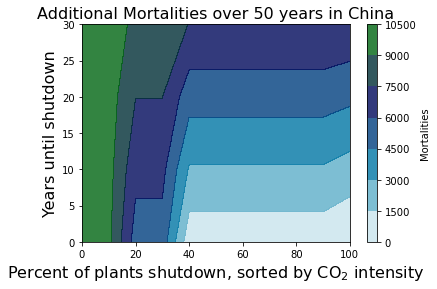

In [134]:
#contours = plt.contour(CO2_df.columns, CO2_df.index[:30], CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
#plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, mort_df[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'Mortalities')
plt.title('Additional Mortalities over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
plt.savefig('figures/china_mort_BC_contours_noco2.pdf', bbox_inches = 'tight', dpi = 350)

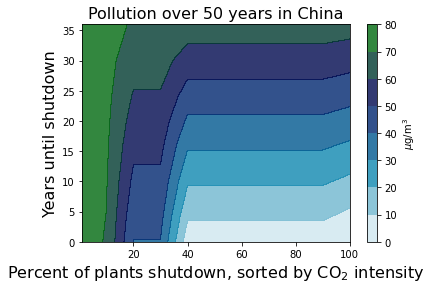

In [133]:
#contours = plt.contour(CO2_df.columns, CO2_df.index[:30], CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
#plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(poll_df.columns, poll_df.index, poll_df[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = r'$\mu$g/m$^3$')
plt.title('Pollution over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
plt.savefig('figures/china_conc_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

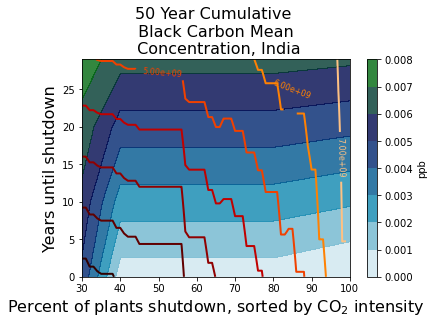

In [368]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_df['India'].dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, India', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/India_sum_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

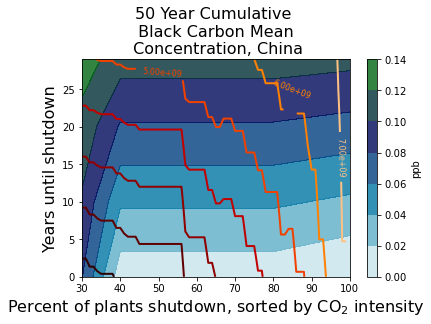

In [369]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_df['China'].astype('float32').dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/China_sum_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

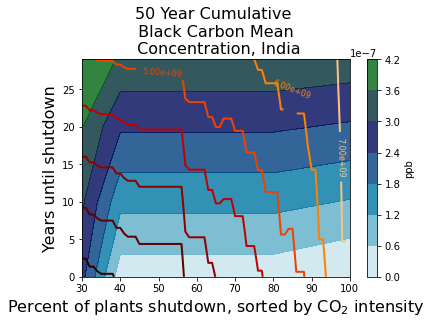

In [370]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_mean_df['India'].dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, India', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/India_mean_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

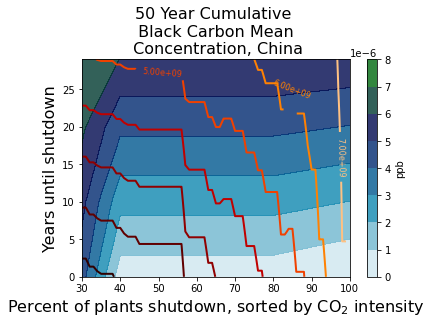

In [371]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_mean_df['China'].astype('float32').dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/China_mean_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

## Country/Map Plots

KeyboardInterrupt: 

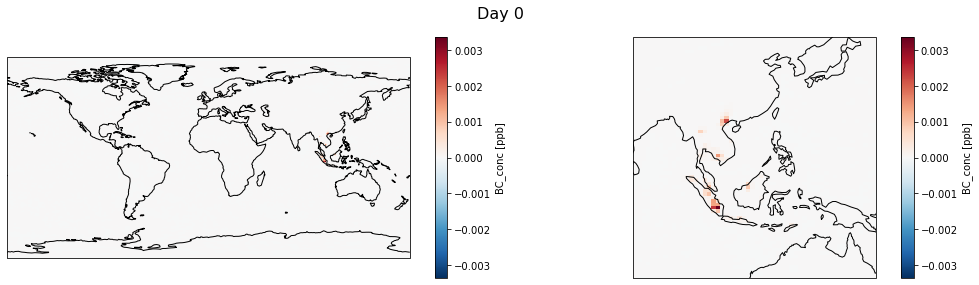

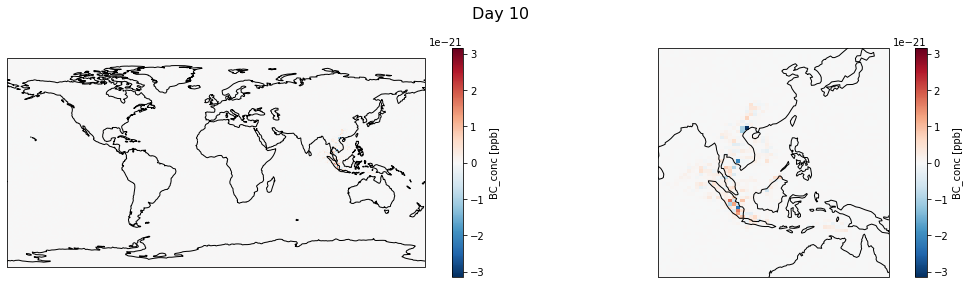

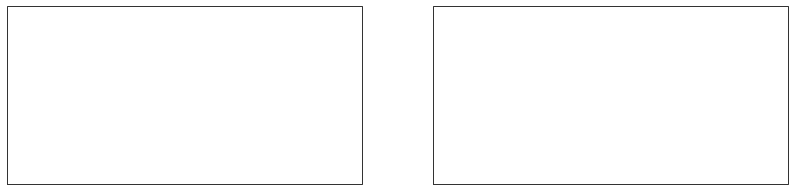

In [319]:
for t in [0,10,20,30]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16), add_colorbar = False,
                                                                               cmap = 'RdBu_r')
    ax1.coastlines()
    ax1.set_title('')
    ##### Zoomed in ########
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                               # norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16),
                                                                               cmap = 'RdBu_r')
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    #plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    #plt.close();

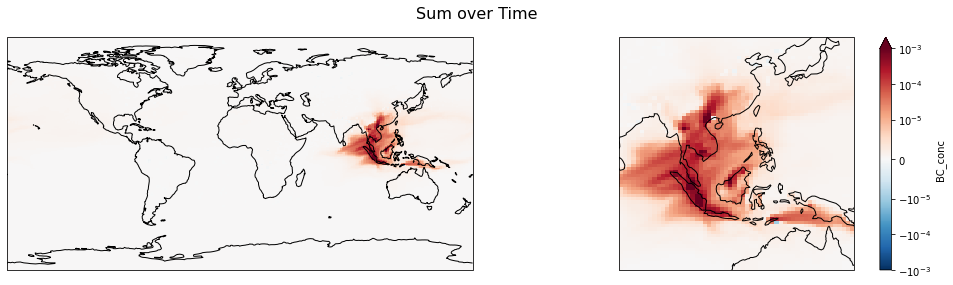

In [321]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/0_100_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();

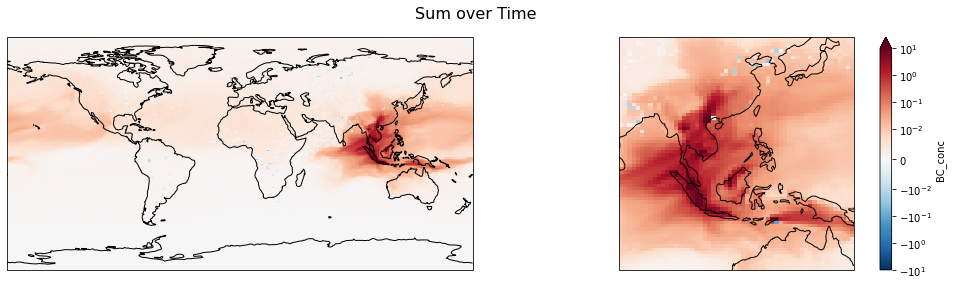

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/30_30_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();